In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import pandas as pd
import pickle
import ccf_analysis_utils
import functions as func
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
epoch = 'response'
r2_method = 'old_clipped'
epochs = ['sample', 'delay', 'response']
method_to_string = {'old': '_old', 'old_clipped': '_old', 'new': ''}
areas = ['Medulla','Midbrain', 'Striatum', 'Thalamus',]
df = pd.read_excel('mousebrainontology_heirarchy_cortexMaskExclusions21_sc.xlsx',engine='openpyxl', header = None, names = ['id','region','tree'])
# correct the annotations
df['region'] = df['region'].replace({'/': ', '}, regex=True)
df['region'] = df['region'].replace({'2, 3': '2/3'}, regex=True)

r2_new = pickle.load(open('r2_data_dict_timeshifts.pkl', 'rb'))

ccf_labels = r2_new['5_0']['ccf_labels'].copy()
ccf_coords = r2_new['5_0']['ccf_coords'].copy()
# center around bregma
ccf_coords[:,0] -= 5700
ccf_coords[:,2] -= 5400

is_alm = r2_new['5_0']['is_alm'].copy()

alm_inds = np.where(is_alm)[0]

In [8]:
figfolder = 'figs/subregions/medulla/'

os.makedirs(figfolder, exist_ok= True)

In [5]:
r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
if r2_method == 'old_clipped':
    r2[r2<0] = 0

fr = r2_new['5_0']['%s_fr'%epoch].copy()

In [9]:
Medulla_subregions = func.get_n_layer_down_subregions_from_name(df, 'Medulla', 1)['region'].values
Medulla_subregions_annotations = {}
for subregion in Medulla_subregions:
    Medulla_subregions_annotations[subregion] = func.get_all_subregion_annotations_from_name(df, subregion)['region'].values
inds = func.get_neuron_inds_for_subregions(ccf_labels, Medulla_subregions_annotations)

n_neurons = [v.shape[0] for v in inds.values()]

In [30]:
timeshifts = [-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16]

timeshifts = np.array(timeshifts)

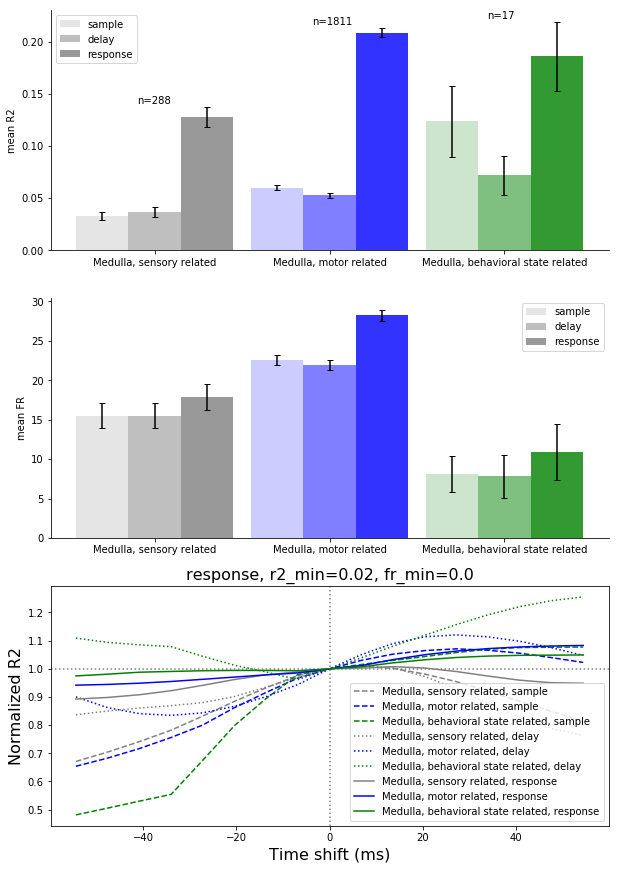

In [42]:
f = plt.figure(figsize=(10,15))
cc = ['grey','blue','green']
epoch_ls = ['dashed','dotted','solid']

ax_bar = f.add_subplot(3,1,1)
for iepoch,epoch in enumerate(epochs):
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    m, sem = func.get_mean_and_sem_for_subregions(r2, inds, Medulla_subregions)
    plt.bar(np.arange(0,len(m)) + (- 0.3 + iepoch*0.3), 
                m, yerr = sem, alpha = 0.2 + iepoch*0.3, color = cc, 
                capsize = 3, width=0.3, label = epoch)
for i in range(len(n_neurons)):
    ax_bar.text(i-0.1, m[i] + sem[i] + 0.1 * max(sem), 'n=%d' % n_neurons[i], fontsize=10, color='black')
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.legend()
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(Medulla_subregions, rotation = 0)
_ = ax_bar.set_ylabel('mean R2')

ax_bar = f.add_subplot(3,1,2)
for iepoch,epoch in enumerate(epochs):
    r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
    if r2_method == 'old_clipped':
        r2[r2<0] = 0

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    m_fr, sem_fr = func.get_mean_and_sem_for_subregions(fr, inds, Medulla_subregions)
    plt.bar(np.arange(0,len(m)) + (- 0.3 + iepoch*0.3), 
                m_fr, yerr = sem_fr, alpha = 0.2 + iepoch*0.3, color = cc, 
                capsize = 3, width=0.3, label = epoch)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.legend()
_ = ax_bar.set_xticks(np.arange(0,len(m)))
_ = ax_bar.set_xticklabels(Medulla_subregions, rotation = 0)
_ = ax_bar.set_ylabel('mean FR')

ax_ts = f.add_subplot(3,1,3)

r2_threshold = .02
fr_threshold = 0.

for iepoch, epoch in enumerate(epochs):

    r2 = []

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    for timesh in timeshifts:
        r2.append(r2_new['5_%d'%timesh]['%s_r2_old'%epoch].copy())

    r2= np.array(r2)
    r2[r2<0] = 0

    fr_inds = np.where(fr > fr_threshold)[0]
    threshold_inds = np.where(r2[8,:] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)



    ax_ts.set_title('%s, r2_min=%.2f, fr_min=%.1f'%(epoch,r2_threshold,fr_threshold), fontsize = 16)
    for j, area in enumerate(inds.keys()):
        this_inds = inds[area]

        this_inds = np.intersect1d(this_inds, threshold_inds)
        avg_r2 = r2[:,this_inds].mean(axis = 1)

        ax_ts.plot(timeshifts*3.4, avg_r2/avg_r2[8],color = cc[j], ls= epoch_ls[iepoch], label = area + ', ' + epoch)

a,b = ax_ts.set_xlim()
ax_ts.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
ax_ts.set_xlim(a,b)

a,b = ax_ts.set_ylim()
ax_ts.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
ax_ts.set_ylim(a,b)

ax_ts.set_xlabel('Time shift (ms)', fontsize = 16)
ax_ts.set_ylabel('Normalized R2', fontsize = 16)
ax_ts.legend()

#plt.savefig(figfolder + 'normalized_r2_timeshifts_r2_fr_threshold.png', dpi = 300)

plt.savefig(figfolder + 'medulla_subregions_1layer_fr_r2_%s.png'%epoch)

Now check what Nuo suggested.

In [79]:
epoch = 'response'
r2_method = 'old_clipped'
r2 = r2_new['5_0']['%s_r2%s'%(epoch, method_to_string[r2_method])].copy()
if r2_method == 'old_clipped':
    r2[r2<0] = 0

fr = r2_new['5_0']['%s_fr'%epoch].copy()

In [80]:
Medulla_motor_nuclei = [ # given by Susu
    'Gigantocellular reticular nucleus',
    'Intermediate reticular nucleus',
    'Parvicellular reticular nucleus',
]

Medulla_behav_nuclei = [ # given by Nuo
]

Medulla_sens_nuclei = []

Medulla_motor_nuclei_all = func.get_n_layer_down_subregions_from_name(df, 'Medulla, motor related', 1)['region'].values
Medulla_behav_nuclei_all = func.get_n_layer_down_subregions_from_name(df, 'Medulla, behavioral state related', 1)['region'].values
Medulla_sens_nuclei_all  = func.get_n_layer_down_subregions_from_name(df, 'Medulla, sensory related', 1)['region'].values


Medulla_motor_nuclei_annotations = {}
for subreg in Medulla_motor_nuclei_all:
    Medulla_motor_nuclei_annotations[subreg] = func.get_all_subregion_annotations_from_name(df, subreg)['region'].values

Medulla_behav_nuclei_annotations = {}
for subreg in Medulla_behav_nuclei_all:
    Medulla_behav_nuclei_annotations[subreg] = func.get_all_subregion_annotations_from_name(df, subreg)['region'].values

Medulla_sens_nuclei_annotations = {}
for subreg in Medulla_sens_nuclei_all:
    Medulla_sens_nuclei_annotations[subreg] = func.get_all_subregion_annotations_from_name(df, subreg)['region'].values



In [81]:
motor_neuron_count = {}

for subreg, subreg_annots in Medulla_motor_nuclei_annotations.items():
    motor_neuron_count[subreg] = func.sum_up_neurons(ccf_labels, subreg_annots)

print('Motor:')
for k,v in motor_neuron_count.items():
    if k in Medulla_motor_nuclei:
        print('*', k,v)
    else:
        print(k,v)

behav_neuron_count = {}

for subreg, subreg_annots in Medulla_behav_nuclei_annotations.items():
    behav_neuron_count[subreg] = func.sum_up_neurons(ccf_labels, subreg_annots)

print('Behavior:')
for k,v in behav_neuron_count.items():
    if k in Medulla_behav_nuclei:
        print('*', k,v)
    else:
        print(k,v)


sens_neuron_count = {}

for subreg, subreg_annots in Medulla_sens_nuclei_annotations.items():
    sens_neuron_count[subreg] = func.sum_up_neurons(ccf_labels, subreg_annots)

print('Sensory:')
for k,v in sens_neuron_count.items():
    if k in Medulla_sens_nuclei:
        print('*', k,v)
    else:
        print(k,v)

Motor:
Abducens nucleus 0
Accessory abducens nucleus 0
Facial motor nucleus 65
Accessory facial motor nucleus 0
Efferent vestibular nucleus 0
Nucleus ambiguus 0
Dorsal motor nucleus of the vagus nerve 25
Efferent cochlear group 0
* Gigantocellular reticular nucleus 544
Infracerebellar nucleus 3
Inferior olivary complex 104
* Intermediate reticular nucleus 208
Inferior salivatory nucleus 0
Linear nucleus of the medulla 0
Lateral reticular nucleus 10
Magnocellular reticular nucleus 214
Medullary reticular nucleus 71
* Parvicellular reticular nucleus 149
Parasolitary nucleus 9
Paragigantocellular reticular nucleus 43
Perihypoglossal nuclei 1
Paramedian reticular nucleus 0
Parapyramidal nucleus 2
Vestibular nuclei 348
Nucleus x 4
Hypoglossal nucleus 11
Nucleus y 0
Interstitial nucleus of the vestibular nerve 0
Behavior:
Nucleus raphe magnus 13
Nucleus raphe pallidus 0
Nucleus raphe obscurus 4
Sensory:
Area postrema 0
Cochlear nuclei 0
Dorsal column nuclei 0
External cuneate nucleus 27
Nucl

In [82]:
motor_inds = func.get_neuron_inds_for_subregions(ccf_labels, Medulla_motor_nuclei_annotations)
behav_inds = func.get_neuron_inds_for_subregions(ccf_labels, Medulla_behav_nuclei_annotations)
sens_inds  = func.get_neuron_inds_for_subregions(ccf_labels, Medulla_sens_nuclei_annotations)

joint_inds = { **sens_inds,**motor_inds, **behav_inds}
joint_Medulla_nuclei = Medulla_motor_nuclei + Medulla_behav_nuclei + Medulla_behav_nuclei

use_Medulla_nuclei = []
neuron_count = []

neuron_threshold = 100
for k,v in joint_inds.items():
    if v.shape[0] > neuron_threshold:
        use_Medulla_nuclei.append(k)
        neuron_count.append(v.shape[0])

In [83]:
num_motor = len(Medulla_motor_nuclei_all)
num_behav = len(Medulla_behav_nuclei_all)
num_sens  = len(Medulla_sens_nuclei_all)

num_motor = len(use_Medulla_nuclei)
num_behav = len(use_Medulla_nuclei)
num_sens  = len(use_Medulla_nuclei)


cmap_motor = plt.cm.get_cmap('Blues', num_motor+3)
cmap_behav = plt.cm.get_cmap('Greens', num_behav+3)
cmap_sens  = plt.cm.get_cmap('Greys', num_sens+3)

joint_color_list = []
imotor = 0
ibehav = 0
isens = 0

for i in range(len(use_Medulla_nuclei)):
    if use_Medulla_nuclei[i] in Medulla_motor_nuclei_all:
        joint_color_list.append(cmap_motor(imotor+3))
        imotor += 1
    elif use_Medulla_nuclei[i] in Medulla_behav_nuclei_all:
        joint_color_list.append(cmap_behav(ibehav+3))
        ibehav += 1
    elif use_Medulla_nuclei[i] in Medulla_sens_nuclei_all:
        joint_color_list.append(cmap_sens(isens+3))
        isens += 1

highlight_mask = np.zeros(len(use_Medulla_nuclei), dtype=bool)
for i in range(len(use_Medulla_nuclei)):
    if use_Medulla_nuclei[i] in Medulla_motor_nuclei:
        highlight_mask[i] = 1
    elif use_Medulla_nuclei[i] in Medulla_behav_nuclei:
        highlight_mask[i] = 1
    elif use_Medulla_nuclei[i] in Medulla_sens_nuclei:
        highlight_mask[i] = 1

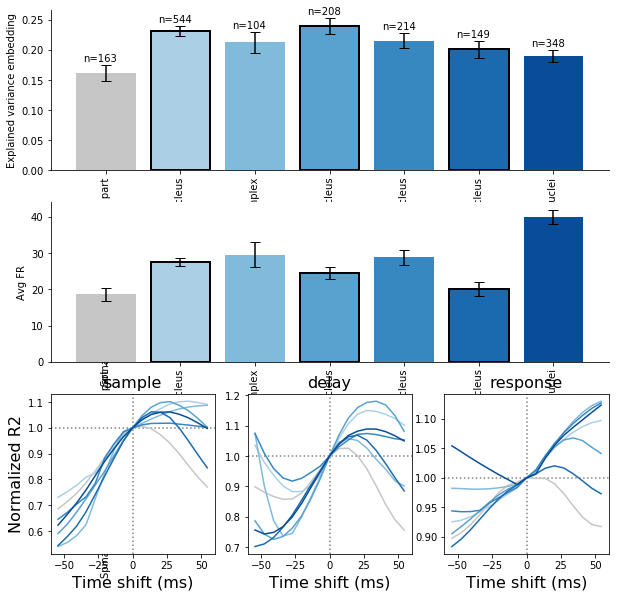

In [87]:
f = plt.figure(figsize=(10,10))
ax_bar = f.add_subplot(3,1,1)
m, sem = func.get_mean_and_sem_for_subregions(r2, joint_inds, use_Medulla_nuclei)
_ = func.plot_barplot_with_sem(ax_bar, m, sem, joint_color_list, use_Medulla_nuclei, 'Explained variance embedding', neuron_count, highlight_mask)


ax_bar = f.add_subplot(3,1,2)
m_fr, sem_fr = func.get_mean_and_sem_for_subregions(fr, joint_inds, use_Medulla_nuclei)
_ = func.plot_barplot_with_sem(ax_bar, m_fr, sem_fr, joint_color_list, use_Medulla_nuclei, 'Avg FR', highlight=highlight_mask)

r2_threshold = .02
fr_threshold = 0.

for iepoch, epoch in enumerate(epochs):
    ax_ts = f.add_subplot(3,3,7 + iepoch)

    this_r2 = []

    fr = r2_new['5_0']['%s_fr'%epoch].copy()

    for timesh in timeshifts:
        this_r2.append(r2_new['5_%d'%timesh]['%s_r2_old'%epoch].copy())

    this_r2= np.array(this_r2)
    this_r2[this_r2<0] = 0

    fr_inds = np.where(fr > fr_threshold)[0]
    threshold_inds = np.where(this_r2[8,:] > r2_threshold)[0]
    threshold_inds = np.intersect1d(threshold_inds, fr_inds)



    ax_ts.set_title('%s'%(epoch), fontsize = 16)
    for j, area in enumerate(use_Medulla_nuclei):
        this_inds = joint_inds[area]

        this_inds = np.intersect1d(this_inds, threshold_inds)
        avg_r2 = this_r2[:,this_inds].mean(axis = 1)

        ax_ts.plot(timeshifts*3.4, avg_r2/avg_r2[8],color = joint_color_list[j], ls= 'solid', label = area + ', ' + epoch)

    a,b = ax_ts.set_xlim()
    ax_ts.hlines(1,a,b,'k',linestyles='dotted', alpha = .5)
    ax_ts.set_xlim(a,b)

    a,b = ax_ts.set_ylim()
    ax_ts.vlines(0,a,b,'k',linestyles='dotted', alpha = .5)
    ax_ts.set_ylim(a,b)

    ax_ts.set_xlabel('Time shift (ms)', fontsize = 16)
    if iepoch == 0: ax_ts.set_ylabel('Normalized R2', fontsize = 16)

plt.savefig(figfolder + 'medulla_subregions_2layer_fr_r2_%s_with_timeshift.png'%epoch, bbox_inches='tight')

In [63]:
plot_dict = dict()
plot_dict['xlim'] = (-2000, 2000)
plot_dict['ylim'] = (4000,7500)
plot_dict['zlim'] = (4000,7500)
plot_dict['axis_zero_label'] = 'ML'
plot_dict['axis_one_label'] = 'DV'
plot_dict['axis_two_label'] = 'AP'

colorlim = (0.,0.5)

if epoch == 'delay':
    colorlim = (0.,0.2)

if epoch == 'sample':
    colorlim = (0,0.2)

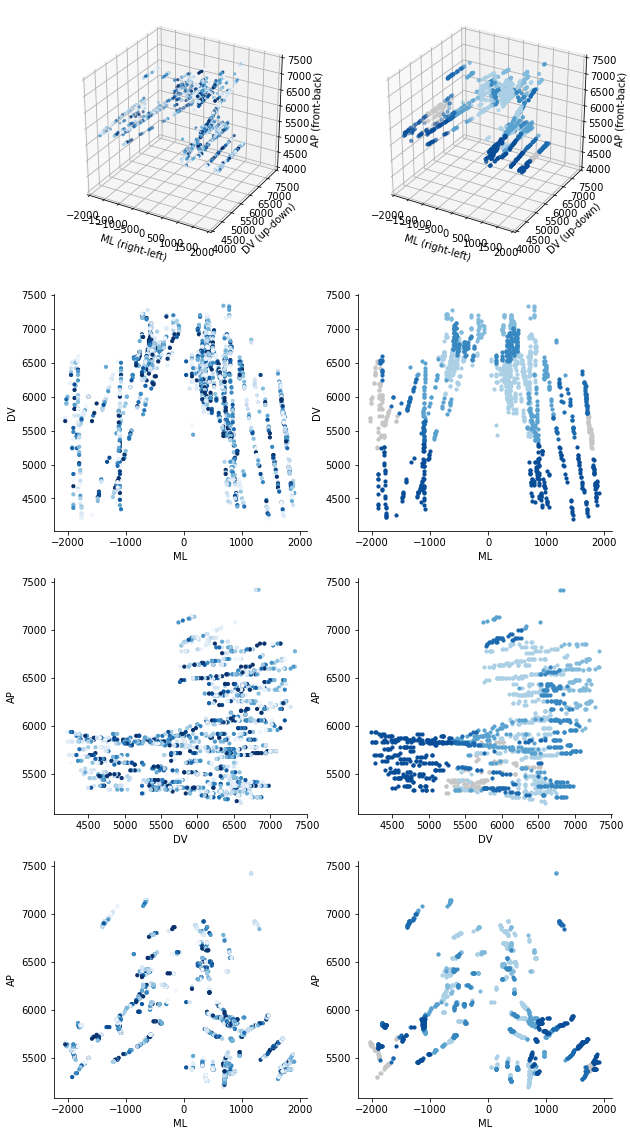

In [64]:
f = plt.figure(figsize=(10,20))
ax = f.add_subplot(4,2,1, projection='3d')
ccf_analysis_utils.add_color_map_plot(ax, use_Medulla_nuclei, joint_inds, r2, ccf_coords, \
                    0, colorlim, True, plot_dict)

ax = f.add_subplot(4,2,2, projection='3d')
ccf_analysis_utils.add_solid_color_plot(ax, use_Medulla_nuclei, joint_inds, r2, \
                     ccf_coords, 0, \
                     joint_color_list, True, {**plot_dict})

ax = f.add_subplot(4,2,3)
three_d_flag = False
ccf_analysis_utils.add_color_map_plot(ax, use_Medulla_nuclei, joint_inds, r2, ccf_coords[:,0:2], \
                    0, colorlim, three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'DV'})

ax = f.add_subplot(4,2,4)
ccf_analysis_utils.add_solid_color_plot(ax, use_Medulla_nuclei, joint_inds, r2, \
                        ccf_coords[:,0:2], 0, \
                        joint_color_list, three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'DV'})

ax = f.add_subplot(4,2,5)
ccf_analysis_utils.add_color_map_plot(ax, use_Medulla_nuclei, joint_inds, r2, ccf_coords[:,1:], \
                    0, colorlim, three_d_flag, {**plot_dict,'xlabel':'DV', 'ylabel':'AP'})

ax = f.add_subplot(4,2,6)
ccf_analysis_utils.add_solid_color_plot(ax, use_Medulla_nuclei, joint_inds, r2, \
                     ccf_coords[:,1:], 0, \
                     joint_color_list, three_d_flag, {**plot_dict,'xlabel':'DV', 'ylabel':'AP'})

ax = f.add_subplot(4,2,7)
ccf_analysis_utils.add_color_map_plot(ax, use_Medulla_nuclei, joint_inds, r2, ccf_coords[:,0::2], \
                    0, colorlim, three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'AP'})

ax = f.add_subplot(4,2,8)
ccf_analysis_utils.add_solid_color_plot(ax, use_Medulla_nuclei, joint_inds, r2, \
                     ccf_coords[:,0::2], 0, \
                     joint_color_list, three_d_flag, {**plot_dict,'xlabel':'ML', 'ylabel':'AP'})

plt.savefig(figfolder + 'medulla_subregions_spatial_maps_%s.pdf'%epoch, bbox_inches='tight')